# 第３章 TensorFlowをもう少し入門 TensorBoard、CNN、モデルの保存


前章でやったのはニューラルネットを作成した。この章では可視化とCNNを行う。

## TensorBoard

1.4.1時点では。。の機能を提供

In [161]:
#-*- coding:utf-8 -*-
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

#mnistデータを格納したオブジェクトを呼び出す
mnist = input_data.read_data_sets("data/", one_hot=True)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


### Images用のログ取得オペレーション

入力されてきたデータをtf.summary.imageに入れることでログで見れるようにする。    
今までは[ミニバッチサイズ、 入力長]の２階テンソルだったが、画像群として扱うために[ミニバッチサイズ、 縦、　横、　チャンネル]の4階テンソルにする。    
summary.imageの１つ目の引数は名前、3個目はログに出す枚数。チャンネルは１、３、４のいずれかである必要がある。1はグレースケール、3はRGB、４はRGBA。

In [3]:
#入力データを定義
x = tf.placeholder(tf.float32, [None, 784], name="x")

#入力画像をログに出力
img = tf.reshape(x,[-1,28,28,1])
tf.summary.image("input_data", img, 10)

<tf.Tensor 'input_data:0' shape=() dtype=string>

### Graphとname_scope

name_scopeで処理をまとめれる。    
中間層、出力層、誤差、訓練、精度測定という処理単位に分けた。    
ログを見るときにも良いし、その層にアクセスするときのも便利。

In [4]:
#入力層から中間層
with tf.name_scope("hidden"):
    w_1 = tf.Variable(tf.truncated_normal([784, 64], stddev=0.1), name="w1")
    b_1 = tf.Variable(tf.zeros([64]), name="b1")
    h_1 = tf.nn.relu(tf.matmul(x, w_1) + b_1)

    #中間層の重みの分布をログ出力
    tf.summary.histogram('w_1',w_1)

#中間層から出力層
with tf.name_scope("output"):
    w_2 = tf.Variable(tf.truncated_normal([64, 10], stddev=0.1), name="w2")
    b_2 = tf.Variable(tf.zeros([10]), name="b2")
    out = tf.nn.softmax(tf.matmul(h_1, w_2) + b_2)

y = tf.placeholder(tf.float32, [None, 10], name="y")

In [5]:
#誤差関数
with tf.name_scope("loss"):    
    loss = tf.reduce_mean(tf.square(y - out))

    #誤差をログ出力
    tf.summary.scalar("loss", loss)

#訓練
with tf.name_scope("train"):
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

#評価
with tf.name_scope("accuracy"):
    correct = tf.equal(tf.argmax(out,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    #精度をログ出力
    tf.summary.scalar("accuracy", accuracy)

# ScalarsとHistograms/Distributions

In [6]:
#初期化
init =tf.global_variables_initializer()

summary_op = tf.summary.merge_all()

with tf.Session() as sess:

    summary_writer = tf.summary.FileWriter("logs", sess.graph)

    sess.run(init)    

    #テストデータをロード    
    test_images = mnist.test.images    
    test_labels = mnist.test.labels    
    
    for step in range(1000):        
        train_images, train_labels = mnist.train.next_batch(50)
        sess.run(train_step, feed_dict={x:train_images ,y:train_labels})

        if step % 10 == 0:
            #ログを取る処理を実行する（出力はログ情報が書かれたプロトコルバッファ）
            summary_str = sess.run(summary_op, feed_dict={x:test_images, y:test_labels})
            #ログ情報のプロトコルバッファを書き込む
            summary_writer.add_summary(summary_str, step)

# TensorBoardの見方

### Histograms/Distributions

Histogramsは度数分布を詳細に確認できて、Distributionsは確率分布を表して、何パーセントのデータが各線の範囲に収まっているかを表す。    
これを元にして荷重減衰の制約がしっかり聞いているか過学習の判定などを行う際に利用。

In [8]:
!ls logs

events.out.tfevents.1526106588.U05000noMacBook-Pro.local
events.out.tfevents.1526106607.U05000noMacBook-Pro.local
events.out.tfevents.1526109115.U05000noMacBook-Pro.local
events.out.tfevents.1526109201.U05000noMacBook-Pro.local
events.out.tfevents.1526109383.U05000noMacBook-Pro.local


In [9]:
#で実行
# !tensorboard --logdir=./logs

/Users/miyamoto/.pyenv/versions/miniconda3-4.1.11/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
2018-05-12 16:17:39.969735: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
W0512 16:17:39.985204 Reloader tf_logging.py:121] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0512 16:17:39.986279 Reloader tf_logging.py:121] Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
W0512 16:17:39.987580 Reloader tf_logging.py:121] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the grap

# ニューラルネットの改善

- ニュラルネットを多層にする    
- 畳み込みニューラルネットを使用する    
- 誤差関数としてクロスエントロピーにする    



In [25]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [62]:
mnist = input_data.read_data_sets("data/", one_hot=False)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [63]:
train_images, train_labels = mnist.train.next_batch(50)

In [136]:
img_zero = train_images[np.where(train_labels == 0)]
img_zero.shape

(5, 784)

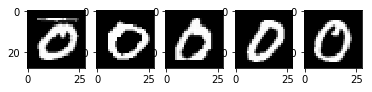

In [104]:
plt.figure(1)
image_num = len(img_zero)
for index in range(image_num):
    plt.subplot(1,int(image_num),int(index+1))
    plt.imshow(np.array(img_zero[int(index)]).reshape(28, 28), cmap='gray')
plt.show()

In [149]:
img_zero[1].shape
np.stack((img_zero[0], img_zero[1]), axis=0).shape

(2, 784)

In [160]:
import pandas as pd
np.random.seed(0)
uniform_data = np.random.rand(10, 12)
data = np.stack((img_zero[0], img_zero[1]), axis=0)
# sns.heatmap(data)
sns.pairplot(pd.DataFrame(data), hue="species")

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x132f49048> (for post_execute):


ValueError: Image size of 141120x141120 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 141120x141120 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 141120x141120 with 3139 Axes>

In [ ]:
# # # plt.figure(1)
# image_num = len(img_zero)
# for index in range(image_num):
#     plt.subplot(1,int(image_num),int(index+1))
#     plt.subplots(figsize=(10,4))
# #     plt.subplots(figsize=(100, 30))
#     plt.imshow(np.array(img_zero[int(index)]).reshape(784, 1), cmap='gray')
# plt.show()


fig, axes = plt.subplots(nrows=1, ncols=5)
for ax in axes.flat:
    im = ax.imshow(np.array(img_zero[int(0)]).reshape(784, 1), cmap='gray')

plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
# # fig.subplots_adjust(right=0.8)
# # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# # fig.colorbar(im, cax=cbar_ax)

plt.show()




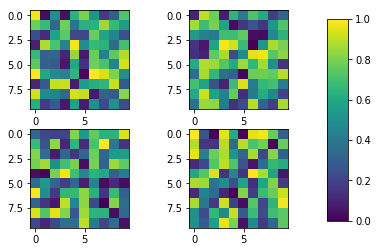

In [120]:
fig, axes = plt.subplots(nrows=2, ncols=2)
for ax in axes.flat:
    im = ax.imshow(np.random.random((10,10)), vmin=0, vmax=1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()


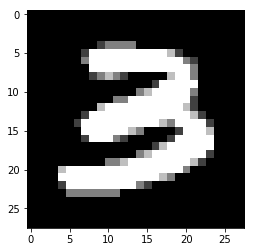

In [31]:
plt.plot(), plt.imshow(np.array(train_images[0]).reshape(28, 28), cmap='gray')
plt.show()

In [61]:
import random

list(train_images).index(3)

# fig, ax = plt.subplots(figsize=(100, 30))
# ax.imshow(np.array(train_images[0]).reshape(784, 1), interpolation='nearest')




# plt.plot(), plt.imshow(np.array(train_images[0]).reshape(784, 1), cmap='gray')
# plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# TensorFlowにおける畳み込みとプーリング

この部分の今までとの違いはreshapeしているところ。28 28に変換。    


In [162]:
#-*- coding:utf-8 -*-
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

#mnistデータを格納したオブジェクトを呼び出す
mnist = input_data.read_data_sets("data/", one_hot=True)

"""モデル構築開始"""
#入力データを定義
x = tf.placeholder(tf.float32, [None, 784], name="conv_sample_x")
#整形
img = tf.reshape(x,[-1,28,28,1])

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


畳み込みとプーリングの組み合わせ    
重みのshapeは[縦、横、チャネル数、フィルタ数（畳み込み後のチャンネル数）]を指定する。    
convの３つ目の引数はストライド。[バッチ方向、縦方向、横方向、チャンネル方向]にどれだけカーネルを移動させるか決めれる。バッチ方向とチャンネル方向を1以外にすることは少ない。    
４つ目の引数はpaddingで横を埋める役割。フィルターサイズの大きさとストライドが大きくなると畳み込み後の画像サイズは小さくなる。画素値0のピクセルを用意してサイズ調整するのがパディング。SAMEを設定するとストライドを１にしても画像サイズは変わらなくなる。VALIDにするとパディングは入らないのでフィルタサイズ分だけ小さくなる。    
プーリングも同じ。

In [163]:
#畳み込み層1
f1 = tf.Variable(tf.truncated_normal([5,5,1,32], stddev=0.1))
conv1 = tf.nn.conv2d(img, f1, strides=[1,1,1,1], padding='SAME')
b1 = tf.Variable(tf.constant(0.1, shape=[32]))
h_conv1 = tf.nn.relu(conv1+b1)

max_poolはフィルタの中から一番大きいものを持ってくる    
ksizeはフィルタサイズstridesはストライドで[バッチ方向、縦方向、横方向、チャンネル方向]を表す。
プーリングは画像縮小するのが目的なので、ストライドは２になってる。    
28 28の画像が14 14 の３２チャンネルの画像になった。

In [164]:
#プーリング層1
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [165]:
#畳み込み層2
f2 = tf.Variable(tf.truncated_normal([5,5,32,64], stddev=0.1))
conv2 = tf.nn.conv2d(h_pool1, f2, strides=[1,1,1,1], padding='SAME')
b2 = tf.Variable(tf.constant(0.1, shape=[64]))
h_conv2 = tf.nn.relu(conv2+b2)
#プーリング層2
h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [166]:
#畳み込まれているものをフラットな形に変換
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

In [167]:
#全結合層
w_fc1 = tf.Variable(tf.truncated_normal([7*7*64, 1024], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

#出力層
w_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
out = tf.nn.softmax(tf.matmul(h_fc1, w_fc2) + b_fc2)

In [175]:
#正解データの型を定義
y = tf.placeholder(tf.float32, [None, 10], name="conv_sample_y")
#誤差関数（クロスエントロピー）
loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(out + 1e-5), axis=[1]))

In [169]:
#訓練
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

#評価
correct = tf.equal(tf.argmax(out,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init =tf.global_variables_initializer()

"""実行部分"""
with tf.Session() as sess:
    sess.run(init)
    #テストデータをロード
    test_images = mnist.test.images
    test_labels = mnist.test.labels

    for step in range(1000):
        train_images, train_labels = mnist.train.next_batch(50)
        sess.run(train_step, feed_dict={x:train_images ,y:train_labels})

        #10階ごとに精度を検証
        if step % 100 == 0:
            acc_val = sess.run( accuracy, feed_dict={x:test_images, y:test_labels})
            print('Step %d: accuracy = %.2f' % (step, acc_val))


Step 0: accuracy = 0.09
Step 100: accuracy = 0.90
Step 200: accuracy = 0.92
Step 300: accuracy = 0.94
Step 400: accuracy = 0.95
Step 500: accuracy = 0.94
Step 600: accuracy = 0.96
Step 700: accuracy = 0.95
Step 800: accuracy = 0.96
Step 900: accuracy = 0.96


正答率90%以上と精度が上がった。

In [12]:
#-*- coding:utf-8 -*-
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

mnist = input_data.read_data_sets("data/", one_hot=True)
x = tf.placeholder(tf.float32, [None, 784], name="save_sample_x")
img = tf.reshape(x,[-1,28,28,1])
f1 = tf.Variable(tf.truncated_normal([5,5,1,32], stddev=0.1))
conv1 = tf.nn.conv2d(img, f1, strides=[1,1,1,1], padding='SAME')
b1 = tf.Variable(tf.constant(0.1, shape=[32]))
h_conv1 = tf.nn.relu(conv1+b1)
#プーリング層1
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
print(h_pool1.shape) #14 14 32で出てる

init =tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    test_images = mnist.test.images
    test_labels = mnist.test.labels

    for step in range(500):
        train_images, train_labels = mnist.train.next_batch(50)
        sess.run(h_pool1, feed_dict={x:train_images})

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
(?, 14, 14, 32)


１層減らしてみた。どこを変更するのか確認した。    
Incompatible shapes: [50,10] vs. [25,10]であって、これは、「50x10の型枠に方眼紙を収めたいのに、25x10じゃ収まらないじゃないか！ぷんぷん」    
https://teratail.com/questions/93251    


In [23]:
#-*- coding:utf-8 -*-
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

mnist = input_data.read_data_sets("data/", one_hot=True)
x = tf.placeholder(tf.float32, [None, 784], name="save_sample_x")
img = tf.reshape(x,[-1,28,28,1])
#conv pool
#重みのshapeは[縦、横、チャネル数、フィルタ数（畳み込み後のチャンネル数）]
f1 = tf.Variable(tf.truncated_normal([5,5,1,32], stddev=0.1))
conv1 = tf.nn.conv2d(img, f1, strides=[1,1,1,1], padding='SAME')
b1 = tf.Variable(tf.constant(0.1, shape=[32]))
h_conv1 = tf.nn.relu(conv1+b1)
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME') #ksizeとstridesを2から4へ変える
print(h_pool1.shape) #?, 7, 7, 32で出てる
#flatten
h_pool2_flat = tf.reshape(h_pool1, [-1, 7*7*32]) #64を32へ
print(h_pool2_flat.shape) #?, 1568で出てる
#fc
w_fc1 = tf.Variable(tf.truncated_normal([7*7*32, 1024], stddev=0.1)) #64を32へ
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)
print(h_fc1.shape) #?, 1024で出てる
#softmax
w_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
out = tf.nn.softmax(tf.matmul(h_fc1, w_fc2) + b_fc2)
print(out.shape) #(?, 10)で出てる

#正解データの型を定義
y = tf.placeholder(tf.float32, [None, 10], name="save_sample_y")
#誤差関数（クロスエントロピー）
loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(out + 1e-5), axis=[1]))

#訓練
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

#評価
correct = tf.equal(tf.argmax(out,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init =tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    test_images = mnist.test.images
    test_labels = mnist.test.labels

    for step in range(500):
        train_images, train_labels = mnist.train.next_batch(50)
        sess.run(train_step, feed_dict={x:train_images ,y:train_labels})
        sess.run(h_pool2_flat, feed_dict={x:train_images})
        if step % 100 == 0:
            acc_val = sess.run( accuracy, feed_dict={x:test_images, y:test_labels})
            print('Step %d: accuracy = %.2f' % (step, acc_val))


Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
(?, 7, 7, 32)
(?, 1568)
(?, 1024)
(?, 10)
Step 0: accuracy = 0.13
Step 100: accuracy = 0.84
Step 200: accuracy = 0.89
Step 300: accuracy = 0.92
Step 400: accuracy = 0.92


# モデルの保存、学習済みモデルの読み込み

### tf.train.Saver()

tfでモデル保存方法はいくつかあるが基本的な方法を説明。    
tf.train.Saver()はtfによって作成されたgraphとVariableの値を保存、読み込みを行うクラス。    


In [3]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [67]:
#-*- coding:utf-8 -*-
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

mnist = input_data.read_data_sets("data/", one_hot=True)
x = tf.placeholder(tf.float32, [None, 784], name="save_sample_x")
img = tf.reshape(x,[-1,28,28,1])
f1 = tf.Variable(tf.truncated_normal([5,5,1,32], stddev=0.1))
conv1 = tf.nn.conv2d(img, f1, strides=[1,1,1,1], padding='SAME')
b1 = tf.Variable(tf.constant(0.1, shape=[32]))
h_conv1 = tf.nn.relu(conv1+b1)
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')
h_pool2_flat = tf.reshape(h_pool1, [-1, 7*7*32])
w_fc1 = tf.Variable(tf.truncated_normal([7*7*32, 1024], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)
w_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
out = tf.nn.softmax(tf.matmul(h_fc1, w_fc2) + b_fc2)
y = tf.placeholder(tf.float32, [None, 10], name="save_sample_y")
loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(out + 1e-5), axis=[1]))
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
correct = tf.equal(tf.argmax(out,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

saver = tf.train.Saver()# add
init =tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    test_images = mnist.test.images
    test_labels = mnist.test.labels

    for step in range(1000):
        train_images, train_labels = mnist.train.next_batch(50)
        sess.run(train_step, feed_dict={x:train_images ,y:train_labels})
        if step % 100 == 0:
            acc_val = sess.run( accuracy, feed_dict={x:test_images, y:test_labels})
            print('Step %d: accuracy = %.2f' % (step, acc_val))

    saver.save(sess, 'ckpt/my_model') #add

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Step 0: accuracy = 0.13
Step 100: accuracy = 0.83
Step 200: accuracy = 0.88
Step 300: accuracy = 0.91
Step 400: accuracy = 0.91
Step 500: accuracy = 0.93
Step 600: accuracy = 0.94
Step 700: accuracy = 0.94
Step 800: accuracy = 0.95
Step 900: accuracy = 0.95


In [37]:
!ls -l ckpt

total 241696
-rw-r--r--  1 miyamoto  staff         73  5 12 19:19 checkpoint
-rw-r--r--  1 miyamoto  staff  122926632  5 12 19:19 my_model.data-00000-of-00001
-rw-r--r--  1 miyamoto  staff       4070  5 12 19:19 my_model.index
-rw-r--r--  1 miyamoto  staff     810099  5 12 19:19 my_model.meta


checkpoint:管理対象のファイルが記載されたファイル    
my_model.data-00000-of-00001:具体的なvariableの値を保持したファイル    
my_model.index：各Tensorとその値の参照箇所などの情報の紐付けが記載されてる    
my_model.meta：計算グラフ及び付随情報を含むメタファイル    


変数の一部のみ保存したい場合

In [38]:
#-*- coding:utf-8 -*-
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

mnist = input_data.read_data_sets("data/", one_hot=True)
x = tf.placeholder(tf.float32, [None, 784], name="save_sample_x")
img = tf.reshape(x,[-1,28,28,1])
f1 = tf.Variable(tf.truncated_normal([5,5,1,32], stddev=0.1))
conv1 = tf.nn.conv2d(img, f1, strides=[1,1,1,1], padding='SAME')
b1 = tf.Variable(tf.constant(0.1, shape=[32]))
h_conv1 = tf.nn.relu(conv1+b1)
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')
h_pool2_flat = tf.reshape(h_pool1, [-1, 7*7*32])
w_fc1 = tf.Variable(tf.truncated_normal([7*7*32, 1024], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)
w_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
out = tf.nn.softmax(tf.matmul(h_fc1, w_fc2) + b_fc2)
y = tf.placeholder(tf.float32, [None, 10], name="save_sample_y")
loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(out + 1e-5), axis=[1]))
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
correct = tf.equal(tf.argmax(out,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

saver_w = tf.train.Saver([f1, w_fc1]) #add
save_param = tf.train.Saver({'param1': f1, 'param2':w_fc1}) #add

init =tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    test_images = mnist.test.images
    test_labels = mnist.test.labels

    for step in range(800):
        train_images, train_labels = mnist.train.next_batch(50)
        sess.run(train_step, feed_dict={x:train_images ,y:train_labels})
        if step % 100 == 0:
            acc_val = sess.run( accuracy, feed_dict={x:test_images, y:test_labels})
            print('Step %d: accuracy = %.2f' % (step, acc_val))

    saver_w.save(sess, 'ckpt2/my_model_w') #add
    save_param.save(sess, 'ckpt2/my_model_param') #add

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Step 0: accuracy = 0.06
Step 100: accuracy = 0.85
Step 200: accuracy = 0.90
Step 300: accuracy = 0.90
Step 400: accuracy = 0.92
Step 500: accuracy = 0.93
Step 600: accuracy = 0.94
Step 700: accuracy = 0.93


In [43]:
!ls -l ckpt2/ | grep my_model_w

-rw-r--r--  1 miyamoto  staff    6425728  5 12 19:25 my_model_w.data-00000-of-00001
-rw-r--r--  1 miyamoto  staff        176  5 12 19:25 my_model_w.index
-rw-r--r--  1 miyamoto  staff     848021  5 12 19:25 my_model_w.meta


In [44]:
!ls -l ckpt2/ | grep my_model_param

-rw-r--r--  1 miyamoto  staff    6425728  5 12 19:25 my_model_param.data-00000-of-00001
-rw-r--r--  1 miyamoto  staff        170  5 12 19:25 my_model_param.index
-rw-r--r--  1 miyamoto  staff     848021  5 12 19:25 my_model_param.meta


# 学習結果のrestore

学習済みモデルの読み込み    
tf.train.get_checkpoint_stateで読み込み、ckpt.model_checkpoint_pathで最後のモデルにアクセス。

In [68]:
#-*- coding:utf-8 -*-
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

mnist = input_data.read_data_sets("data/", one_hot=True)
x = tf.placeholder(tf.float32, [None, 784], name="save_sample_x")
img = tf.reshape(x,[-1,28,28,1])
f1 = tf.Variable(tf.truncated_normal([5,5,1,32], stddev=0.1))
conv1 = tf.nn.conv2d(img, f1, strides=[1,1,1,1], padding='SAME')
b1 = tf.Variable(tf.constant(0.1, shape=[32]))
h_conv1 = tf.nn.relu(conv1+b1)
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')
h_pool2_flat = tf.reshape(h_pool1, [-1, 7*7*32])
w_fc1 = tf.Variable(tf.truncated_normal([7*7*32, 1024], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)
w_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
out = tf.nn.softmax(tf.matmul(h_fc1, w_fc2) + b_fc2)
y = tf.placeholder(tf.float32, [None, 10], name="save_sample_y")
loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(out + 1e-5), axis=[1]))
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
correct = tf.equal(tf.argmax(out,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init =tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    ckpt = tf.train.get_checkpoint_state('ckpt/') #対象パスにあるcheckpointファイルを読む。なければNone。
    if ckpt: # checkpointがある場合
        last_model = ckpt.model_checkpoint_path # 最後に保存したmodelへのパス
        print("load " + last_model)
        saver.restore(sess, last_model) # 変数データの読み込み
    else:
        print("no model")
    test_images = mnist.test.images
    test_labels = mnist.test.labels
    acc_val = sess.run( accuracy, feed_dict={x:test_images, y:test_labels})
    print('Step %d: accuracy = %.2f' % (step, acc_val))

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
load ckpt/my_model
INFO:tensorflow:Restoring parameters from ckpt/my_model
Step 999: accuracy = 0.12


In [77]:
#-*- coding:utf-8 -*-
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

mnist = input_data.read_data_sets("data/", one_hot=True)
x = tf.placeholder(tf.float32, [None, 784], name="save_sample_x")
img = tf.reshape(x,[-1,28,28,1])
f1 = tf.Variable(tf.truncated_normal([5,5,1,32], stddev=0.1))
conv1 = tf.nn.conv2d(img, f1, strides=[1,1,1,1], padding='SAME')
b1 = tf.Variable(tf.constant(0.1, shape=[32]))
h_conv1 = tf.nn.relu(conv1+b1)
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')
h_pool2_flat = tf.reshape(h_pool1, [-1, 7*7*32])
w_fc1 = tf.Variable(tf.truncated_normal([7*7*32, 1024], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)
w_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
out = tf.nn.softmax(tf.matmul(h_fc1, w_fc2) + b_fc2)
y = tf.placeholder(tf.float32, [None, 10], name="save_sample_y")
loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(out + 1e-5), axis=[1]))
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
correct = tf.equal(tf.argmax(out,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init =tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    ckpt = tf.train.get_checkpoint_state('ckpt/')
    if ckpt:
        last_model = ckpt.all_model_checkpoint_paths #モデルを全部取る
        print(len(last_model))
        print("load " + last_model[0])
        saver.restore(sess, last_model[0]) #あるモデルをインデックスで指定してリストア
    else:
        print("no model")
    test_images = mnist.test.images
    test_labels = mnist.test.labels
    acc_val = sess.run( accuracy, feed_dict={x:test_images, y:test_labels})
    print('Step %d: accuracy = %.2f' % (step, acc_val))

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
1
load ckpt/my_model
INFO:tensorflow:Restoring parameters from ckpt/my_model
Step 999: accuracy = 0.10


# グローバルステップ

何ステップ目で学習が止まったかなどを保持してないとTensorBoardと組み合わせたいときに困るのでglobal_stepもモデル内に保存する。global_stepという引数を指定するだけ。

global_stepを保持する変数を作って、１ずつ増やしたかったが休日でボーッとしてたのか結構ハマった。    
下の計算グラフには誤りがあります。    
global_stepを１ずつ増やしたかったらどうすればいいでしょう。    

In [26]:
#-*- coding:utf-8 -*-
import tensorflow as tf

global_step = tf.Variable(0, name="global_step") #定義
global_step = tf.assign(global_step, 1)

saver = tf.train.Saver()
init =tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(10):
        print(sess.run(global_step))

1
1
1
1
1
1
1
1
1
1


tf.assignは代入だけども右の引数にはオペレーションを入れる。

In [27]:
#-*- coding:utf-8 -*-
import tensorflow as tf

step_index = tf.Variable(1)
global_step = tf.Variable(0, name="global_step") #定義
add = tf.add(step_index, global_step)

global_step = tf.assign(global_step, add)

saver = tf.train.Saver()
init =tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(10):
        print(sess.run(global_step, feed_dict={}))

1
2
3
4
5
6
7
8
9
10


In [32]:
#-*- coding:utf-8 -*-
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

mnist = input_data.read_data_sets("data/", one_hot=True)
x = tf.placeholder(tf.float32, [None, 784], name="global_step_sample_x")
img = tf.reshape(x,[-1,28,28,1])
f1 = tf.Variable(tf.truncated_normal([5,5,1,32], stddev=0.1))
conv1 = tf.nn.conv2d(img, f1, strides=[1,1,1,1], padding='SAME')
b1 = tf.Variable(tf.constant(0.1, shape=[32]))
h_conv1 = tf.nn.relu(conv1+b1)
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')
h_pool2_flat = tf.reshape(h_pool1, [-1, 7*7*32])
w_fc1 = tf.Variable(tf.truncated_normal([7*7*32, 1024], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)
w_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
out = tf.nn.softmax(tf.matmul(h_fc1, w_fc2) + b_fc2)
y = tf.placeholder(tf.float32, [None, 10], name="global_step_sample_y")
loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(out + 1e-5), axis=[1]))
#global step
step_index = tf.Variable(1)
global_step = tf.Variable(0, name="global_step")
add = tf.add(step_index, global_step)
global_step = tf.assign(global_step, add)

# override global_step here
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss, global_step=global_step) 

correct = tf.equal(tf.argmax(out,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

saver = tf.train.Saver()
init =tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    test_images = mnist.test.images    
    test_labels = mnist.test.labels    

    for step in range(300):
        sess.run(global_step) # updete number of train global step
        train_images, train_labels = mnist.train.next_batch(50)
        sess.run(train_step, feed_dict={x:train_images ,y:train_labels})
        if step % 100 == 0:
            acc_val = sess.run( accuracy, feed_dict={x:test_images, y:test_labels})
            print('Step %d: accuracy = %.2f' % (step, acc_val))
    
    saver.save(sess, 'ckpt/my_model', global_step = global_step, write_meta_graph=False)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Step 0: accuracy = 0.12
Step 100: accuracy = 0.85
Step 200: accuracy = 0.90


global_stepを指定してモデルの読み込み

In [34]:
#-*- coding:utf-8 -*-
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

mnist = input_data.read_data_sets("data/", one_hot=True)
x = tf.placeholder(tf.float32, [None, 784], name="global_step_sample_x")
img = tf.reshape(x,[-1,28,28,1])
f1 = tf.Variable(tf.truncated_normal([5,5,1,32], stddev=0.1))
conv1 = tf.nn.conv2d(img, f1, strides=[1,1,1,1], padding='SAME')
b1 = tf.Variable(tf.constant(0.1, shape=[32]))
h_conv1 = tf.nn.relu(conv1+b1)
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')
h_pool2_flat = tf.reshape(h_pool1, [-1, 7*7*32])
w_fc1 = tf.Variable(tf.truncated_normal([7*7*32, 1024], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)
w_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
out = tf.nn.softmax(tf.matmul(h_fc1, w_fc2) + b_fc2)
y = tf.placeholder(tf.float32, [None, 10], name="global_step_sample_y")
loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(out + 1e-5), axis=[1]))
#global step
step_index = tf.Variable(1)
global_step = tf.Variable(0, name="global_step")
add = tf.add(step_index, global_step)
global_step = tf.assign(global_step, add)

# override global_step here
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss, global_step=global_step) 

correct = tf.equal(tf.argmax(out,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init =tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    ckpt = tf.train.get_checkpoint_state('ckpt/')
    if ckpt:
        last_model = ckpt.model_checkpoint_path
        print("load " + last_model)
        saver.restore(sess, last_model)
    else:
        print("no model")
    test_images = mnist.test.images
    test_labels = mnist.test.labels
    acc_val = sess.run( accuracy, feed_dict={x:test_images, y:test_labels})
    print('Step %d: accuracy = %.2f' % (step, acc_val))

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
load ckpt/my_model-901
INFO:tensorflow:Restoring parameters from ckpt/my_model-901
Step 299: accuracy = 0.14


Step 299とちゃんと記録されてる。

In [15]:

#セッション上の計算グラフをクリア#セッション上の 
tf.reset_default_graph()

In [16]:
#インライン　テンソルボード
from IPython.display import clear_output, Image, display, HTML
import numpy as np

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [19]:
show_graph(tf.get_default_graph().as_graph_def()) # show graph